In [40]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [41]:
import os
import pandas as pd

benign_dirs = [ r'\\ZAHIN\Users\\zahii\\Desktop\\Benign cases']

Malignant_dir = [ r'\\ZAHIN\\Users\\zahii\\Desktop\\Malignant cases']

Normal_dirs = [r'\\ZAHIN\\Users\\zahii\\Desktop\\Normal cases']

filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

                                           filepaths  labels
0  \\ZAHIN\Users\\zahii\\Desktop\\Benign cases\Be...  benign
1  \\ZAHIN\Users\\zahii\\Desktop\\Benign cases\Be...  benign
2  \\ZAHIN\Users\\zahii\\Desktop\\Benign cases\Be...  benign
3  \\ZAHIN\Users\\zahii\\Desktop\\Benign cases\Be...  benign
4  \\ZAHIN\Users\\zahii\\Desktop\\Benign cases\Be...  benign
labels
Malignant    122
Normal       120
benign       100
Name: count, dtype: int64


In [42]:
Lung_df.shape

(342, 2)

In [43]:
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Lung_df, test_size=0.2, random_state=42)

In [44]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(273, 2)
(103, 2)
(69, 2)
(239, 2)


In [45]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 272 validated image filenames belonging to 3 classes.
Found 103 validated image filenames belonging to 3 classes.
Found 69 validated image filenames belonging to 3 classes.


In [46]:
classes=list(train.class_indices.keys())
print (classes)

['Malignant', 'Normal', 'benign']


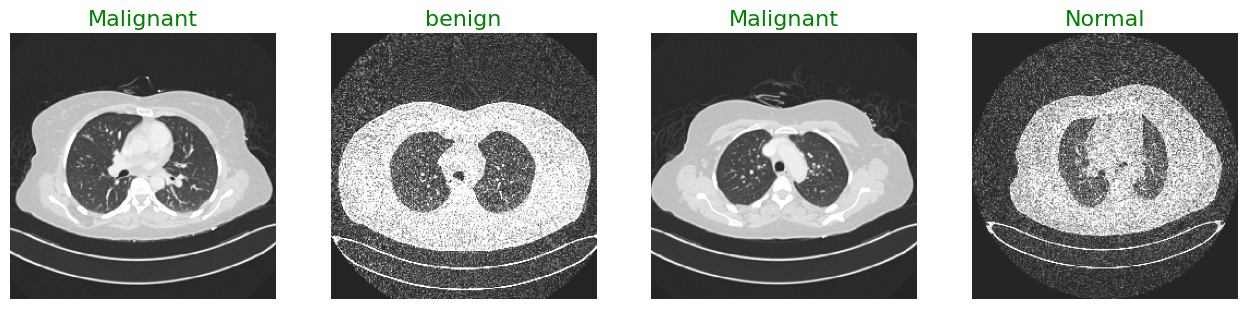

In [47]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [48]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 6, 6, 512)      │         2,04

 Total params: 15,610,499 (59.55 MB)

 Trainable params: 15,604,099 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [49]:
pip install pydot

In [2]:
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense

# Step 1: Define the model
model = Sequential([
    Dense(32, activation='relu', input_shape=(64, 64, 3)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Step 2: Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


C:\Users\zahii\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [26]:
import pandas as pd
import os

# Define the directories
benign_dir = r'\\ZAHIN\\Users\\zahii\\Desktop\\Benign cases'
malignant_dir = r'\\ZAHIN\\Users\\zahii\\Desktop\\Malignant cases'
normal_dir = r'\\ZAHIN\\Users\\zahii\\Desktop\\Normal cases'

# Initialize lists to hold filepaths and labels
filepaths = []
labels = []

# Function to add image paths and labels to the lists
def add_images_to_list(directory, label):
    for filename in os.listdir(directory):
        filepaths.append(os.path.join(directory, filename))
        labels.append(label)

# Add images for each class
add_images_to_list(benign_dir, 'benign')
add_images_to_list(malignant_dir, 'malignant')
add_images_to_list(normal_dir, 'normal')

# Create pandas DataFrames for train_set and val_set
# Assuming you want to split your data into 80% training and 20% validation
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets (80% train, 20% validation)
data = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)

# Check the first few rows of the train_set and val_set
print(train_set.head())
print(val_set.head())




                                             filepaths     labels
154  \\ZAHIN\\Users\\zahii\\Desktop\\Normal cases\N...     normal
211  \\ZAHIN\\Users\\zahii\\Desktop\\Normal cases\N...     normal
118  \\ZAHIN\\Users\\zahii\\Desktop\\Malignant case...  malignant
195  \\ZAHIN\\Users\\zahii\\Desktop\\Normal cases\N...     normal
240  \\ZAHIN\\Users\\zahii\\Desktop\\Normal cases\N...     normal
                                             filepaths     labels
33   \\ZAHIN\\Users\\zahii\\Desktop\\Malignant case...  malignant
6    \\ZAHIN\\Users\\zahii\\Desktop\\Malignant case...  malignant
181  \\ZAHIN\\Users\\zahii\\Desktop\\Normal cases\N...     normal
86   \\ZAHIN\\Users\\zahii\\Desktop\\Malignant case...  malignant
155  \\ZAHIN\\Users\\zahii\\Desktop\\Normal cases\N...     normal


In [16]:
train_set = pd.DataFrame({'filepaths': ['path_to_image1', 'path_to_image2', ...], 'labels': ['benign', 'malignant', ...]})
val_set = pd.DataFrame({'filepaths': ['path_to_image1', 'path_to_image2', ...], 'labels': ['benign', 'malignant', ...]})

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define ImageDataGenerator for preprocessing (using MobileNetV2's preprocess_input function)
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Create the training data generator
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Resize images to 224x224
    color_mode='rgb',
    class_mode="categorical",  # Multi-class classification
    batch_size=4,
    shuffle=True  # Shuffle training data
)

# Create the validation data generator
val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",  # Multi-class classification
    batch_size=4,
    shuffle=False  # Don't shuffle validation data
)


Found 197 validated image filenames belonging to 3 classes.
Found 50 validated image filenames belonging to 2 classes.


In [50]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

In [51]:
from sklearn.utils import class_weight

# Calculate class weights based on the frequencies of the labels
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(train_set['labels']), 
    y=train_set['labels']
)

# Convert to a dictionary where the keys are the class labels
class_weight_dict = dict(zip(np.unique(train_set['labels']), class_weights))

# Print class weights
print(class_weight_dict)

{'Malignant': np.float64(0.9381443298969072), 'Normal': np.float64(0.9285714285714286), 'benign': np.float64(1.1666666666666667)}


In [59]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to the training and validation data
train_dir = r"\\ZAHIN\Users\zahii\Desktop\train"
val_dir = r"\\ZAHIN\Users\zahii\Desktop\val"


# Preprocess the images
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Load the images and apply the preprocessing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 341 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential()

# Add convolutional layers with max pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(3, activation='softmax'))  # 3 output classes (benign, malignant, normal)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [89]:
history = model.fit(
    train_generator,          # Training data generator
    epochs=50,                # Number of epochs
    validation_data=validation_generator,  # Validation data generator
    verbose=1                 # Verbosity level (1 for progress bar)
)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8755 - loss: 0.2615 - val_accuracy: 0.9091 - val_loss: 0.1684
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9081 - loss: 0.2504 - val_accuracy: 0.9296 - val_loss: 0.1450
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8789 - loss: 0.2778 - val_accuracy: 0.9707 - val_loss: 0.1265
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8985 - loss: 0.2358 - val_accuracy: 0.9472 - val_loss: 0.1231
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8958 - loss: 0.2384 - val_accuracy: 0.9296 - val_loss: 0.1582
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8410 - loss: 0.3751 - val_accuracy: 0.9003 - val_loss: 0.2029
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8604 - loss: 0.3078 - val_accuracy: 0.8446 - val_loss: 0.3109
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8976 - loss: 0.2840 - val_accuracy: 0.9326 - val_loss:

In [90]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)

# Convert accuracy to percentage
accuracy_percentage = accuracy * 100

# Print the results
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy_percentage:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 779ms/step - accuracy: 0.9272 - loss: 0.1566
Validation Loss: 0.1526339203119278
Validation Accuracy: 92.96%


In [101]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the correct path to your test data folder
test_dir = r"\\ZAHIN\Users\zahii\Desktop\test"  # Correct the path here

# Create the test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,                  # Path to the test folder
    target_size=(150, 150),    # Resize images to 150x150
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    shuffle=False              # Do not shuffle for evaluation/prediction
)



Found 341 images belonging to 3 classes.


In [103]:
import numpy as np

# Predict on the test data
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)  # Pick class with the highest probability

# Map class indices back to the class names
labels = (train_generator.class_indices)  # Get the class labels from training data
labels = dict((v,k) for k,v in labels.items())  # Reverse the dictionary to map indices to class names
pred2 = [labels[k] for k in pred]  # Get the class names based on predicted indices


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 993ms/step


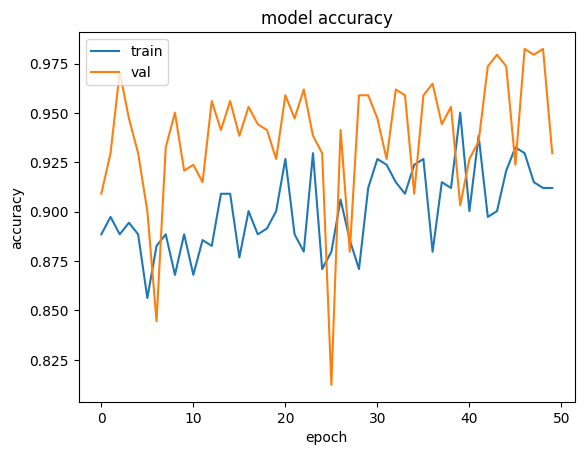

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

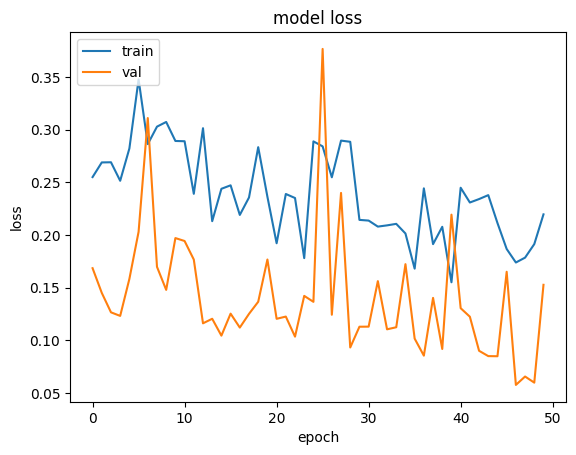

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [114]:
model.save('keras_lung_cancer_model.h5')